In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('04-data/preprocessed_app_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22015 entries, 0 to 22014
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     22015 non-null  object 
 1   description               22015 non-null  object 
 2   summary                   22014 non-null  object 
 3   installs                  22015 non-null  object 
 4   minInstalls               22015 non-null  float64
 5   score                     22015 non-null  float64
 6   ratings                   22015 non-null  float64
 7   reviews                   22015 non-null  float64
 8   histogram                 22015 non-null  object 
 9   price                     22015 non-null  float64
 10  free                      22015 non-null  int64  
 11  currency                  22015 non-null  object 
 12  sale                      22015 non-null  bool   
 13  offersIAP                 22015 non-null  bool   
 14  inAppP

In [3]:
df_sentiment = pd.read_csv('04-data/sentiment_topics_apps.csv')

In [4]:
df= pd.merge(
    df,
    df_sentiment,
    how="inner",
    on='appId',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [5]:
df.shape

(22002, 63)

In [6]:
df.columns

Index(['title', 'description', 'summary', 'installs', 'minInstalls', 'score',
       'ratings', 'reviews', 'histogram', 'price', 'free', 'currency', 'sale',
       'offersIAP', 'inAppProductPrice', 'size', 'androidVersion',
       'androidVersionText', 'developer', 'developerId', 'privacyPolicy',
       'developerInternalID', 'genre', 'genreId', 'icon', 'headerImage',
       'screenshots', 'video', 'videoImage', 'contentRating',
       'contentRatingDescription', 'adSupported', 'containsAds', 'released',
       'updated', 'version', 'recentChanges', 'comments', 'editorsChoice',
       'appId', 'url', 'year', 'updated_year', 'description_clean',
       'hist_clean', 'star_1', 'star_2', 'star_3', 'star_4', 'star_5',
       'top_developer', 'current_date', 'days', 'installs_day', 'updated_days',
       'has_video', 'app_ads', 'compatibility', 'updates', 'features', 'bugs',
       'payments', 'use_support'],
      dtype='object')

In [7]:
X = df[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer',
        'installs_day','updated_days','has_video', 'app_ads', 'compatibility', 'updates', 
        'features', 'bugs','payments', 'use_support']]

y = df['score']

In [8]:
# Split to create temporary tr and test 
X_tr, X_test, y_tr, y_test = train_test_split(X, y,test_size=.20, random_state=10)

In [9]:
X_tr_cont = X_tr[['ratings','free','containsAds','editorsChoice','top_developer',
        'installs_day','updated_days','has_video', 'app_ads', 'compatibility', 'updates', 'features', 'bugs',
       'payments', 'use_support','year']]

In [10]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_tr[['genre','contentRating']])

ohe_x_tr = ohe.transform(X_tr[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_tr_df = pd.DataFrame(ohe_x_tr, columns=columns, index=X_tr.index)

In [11]:
combo_train_df = pd.concat([X_tr_cont, ohe_x_tr_df], axis=1)

In [12]:
# Further split temporary tr to create train and val
X_train, X_val, y_train, y_val = train_test_split(combo_train_df, y_tr,test_size=.20, random_state=10)

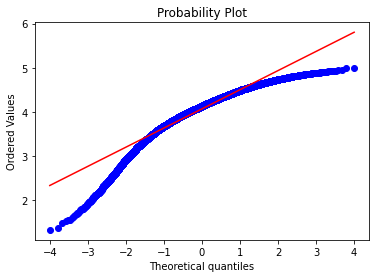

In [13]:
from scipy import stats 
fig = plt.figure() 
prob = stats.probplot(df['score'], plot=plt)

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


- Total number of ratings: 22002
- Mean of distribution of rating : 4.0676669003726715
- Standard deviation: 0.4492370615817515


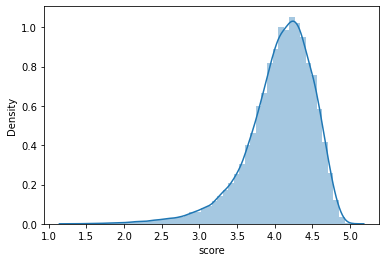

In [14]:
sns.distplot(df['score'])
print('- Total number of ratings:', len(df['score']))
print('- Mean of distribution of rating :', np.mean(df['score']))
print('- Standard deviation:', np.std(df['score']))
plt.savefig('test.svg')

## No pipeline

In [15]:
features = ['ratings', 'free', 'containsAds', 'editorsChoice', 
       'top_developer', 'installs_day', 'updated_days', 'has_video',
       'app_ads', 'compatibility', 'updates', 'features', 'bugs',
       'payments', 'use_support', 'year',
       'genre_Adventure', 'genre_Arcade', 'genre_Art & Design',
       'genre_Auto & Vehicles', 'genre_Beauty', 'genre_Board',
       'genre_Books & Reference', 'genre_Business', 'genre_Card',
       'genre_Casino', 'genre_Casual', 'genre_Comics', 'genre_Communication',
       'genre_Dating', 'genre_Education', 'genre_Entertainment',
       'genre_Events', 'genre_Finance', 'genre_Food & Drink',
       'genre_Health & Fitness', 'genre_House & Home',
       'genre_Libraries & Demo', 'genre_Lifestyle', 'genre_Maps & Navigation',
       'genre_Medical', 'genre_Music & Audio',
       'genre_News & Magazines', 'genre_Parenting', 'genre_Personalization',
       'genre_Photography', 'genre_Productivity', 'genre_Puzzle',
       'genre_Racing', 'genre_Role Playing', 'genre_Shopping',
       'genre_Simulation', 'genre_Social', 'genre_Sports', 'genre_Strategy',
       'genre_Tools', 'genre_Travel & Local', 'genre_Trivia',
       'genre_Video Players & Editors', 'genre_Weather', 'genre_Word',
       'contentRating_Everyone 10+', 'contentRating_Mature 17+',
       'contentRating_Teen']

In [16]:
lr = LinearRegression()

lr.fit(X_train[features], y_train)

y_pred = lr.predict(X_val[features])
print('R^2 of linear regression on val set: {:.2f}'.format(lr.score(X_val[features], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred))))

R^2 of linear regression on val set: 0.30
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.28


In [17]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features].columns, lr.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : 0.08
containsAds : 0.11
editorsChoice : 0.02
top_developer : 0.47
installs_day : 0.00
updated_days : -0.00
has_video : 0.04
app_ads : 0.23
compatibility : 0.03
updates : -0.01
features : 0.88
bugs : -0.01
payments : 0.06
use_support : 0.05
year : -0.00
genre_Adventure : -0.08
genre_Arcade : 0.03
genre_Art & Design : 0.04
genre_Auto & Vehicles : 0.11
genre_Beauty : -0.09
genre_Board : 0.08
genre_Books & Reference : 0.17
genre_Business : 0.14
genre_Card : 0.13
genre_Casino : 0.15
genre_Casual : -0.03
genre_Comics : -0.06
genre_Communication : 0.06
genre_Dating : 0.10
genre_Education : 0.09
genre_Entertainment : -0.03
genre_Events : -0.39
genre_Finance : 0.12
genre_Food & Drink : 0.15
genre_Health & Fitness : 0.12
genre_House & Home : 0.15
genre_Libraries & Demo : -0.17
genre_Lifestyle : 0.02
genre_Maps & Navigation : 0.10
genre_Medical : 0.04
genre_Music & Audio : 0.06
genre_News & Magazines : -0.04
genre_Parenting : 0.08
genre_Persona

In [18]:
check = X_val.copy()
check['score'] = y_val
check['pred'] = lr.predict(X_val[features])
check['resid'] = check['pred'] - check['score']

In [19]:
high_resid = check.sort_values('resid',ascending =False).head(600)

In [20]:
check.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
14784,25281.0,1,0,0,0,354.609929,41,0,0.658800,0.043330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,4.031638,2.158216
2534,1372.0,1,1,0,0,578.703704,1118,0,0.227336,0.423020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.868613,3.977243,2.108630
18209,11487.0,1,1,0,0,580.383053,14,0,0.250500,0.129805,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.910268,3.949339,2.039071
6737,3502.0,1,1,0,0,660.938533,122,0,-0.001850,0.254856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.822857,3.850785,2.027928
3356,3121.0,1,1,0,0,1436.781609,271,0,0.343820,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.729299,3.750395,2.021096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20297,8592.0,1,0,0,0,329.597891,10,0,-0.147575,0.201421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.563927,3.674733,-0.889194
5411,8271.0,1,0,0,0,433.087917,111,0,0.178025,0.102985,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.663485,3.763200,-0.900285
16799,36398.0,1,0,0,0,1388.888889,75,0,-0.101625,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.592755,3.686192,-0.906563
19006,5045.0,1,0,0,0,1602.564103,2,0,0.000000,0.078467,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.563601,3.655382,-0.908219


In [21]:
low_resid = check[(check['resid'] >= -0.1) & (check['resid'] <= 0.1)]

In [22]:
high_resid.describe()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
count,600.000000,600.000000,600.000000,600.000000,600.00000,600.000000,600.000000,600.000000,600.000000,600.000000,...,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,20144.565000,0.990000,0.778333,0.010000,0.03000,956.421551,356.435000,0.301667,0.245297,0.137937,...,0.001667,0.023333,0.010000,0.016667,0.050000,0.036667,0.141667,3.401678,4.029120,0.627443
std,41452.860692,0.099582,0.415715,0.099582,0.17073,955.809108,465.831523,0.459364,0.229066,0.257084,...,0.040825,0.151086,0.099582,0.128126,0.218127,0.188099,0.348999,0.505348,0.303299,0.352631
min,1021.000000,0.000000,0.000000,0.000000,0.00000,247.892910,0.000000,0.000000,-0.743000,-0.711500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.696825,3.446964,0.281528
25%,4214.250000,1.000000,1.000000,0.000000,0.00000,430.061299,48.000000,0.000000,0.112984,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.158654,3.843833,0.369545
50%,7953.500000,1.000000,1.000000,0.000000,0.00000,642.880701,183.000000,0.000000,0.245814,0.109508,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.436010,3.970369,0.504366
75%,15443.750000,1.000000,1.000000,0.000000,0.00000,1066.953240,482.250000,1.000000,0.394823,0.259944,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.688479,4.135722,0.778960
max,311517.000000,1.000000,1.000000,1.000000,1.00000,8695.652174,3032.000000,1.000000,0.859800,0.981700,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.885803,5.667438,2.158216


In [23]:
low_resid.describe()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
count,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,...,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000,829.000000
mean,20701.978287,0.996381,0.833534,0.006031,0.104946,937.409890,382.446321,0.354644,0.283191,0.147411,...,0.003619,0.013269,0.010856,0.003619,0.045838,0.039807,0.195416,4.118180,4.116536,-0.001644
std,27576.467516,0.060084,0.372723,0.077474,0.306668,881.136074,539.184662,0.478694,0.198533,0.288885,...,0.060084,0.114493,0.103690,0.060084,0.209261,0.195624,0.396760,0.273238,0.269197,0.057103
min,1144.000000,0.000000,0.000000,0.000000,0.000000,247.035573,0.000000,0.000000,-0.478200,-0.944700,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.483620,3.495551,-0.099862
25%,5391.000000,1.000000,1.000000,0.000000,0.000000,430.107527,37.000000,0.000000,0.162367,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.940268,3.938719,-0.047827
50%,10813.000000,1.000000,1.000000,0.000000,0.000000,661.375661,158.000000,0.000000,0.288262,0.101021,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.065331,4.064956,0.000830
75%,23527.000000,1.000000,1.000000,0.000000,0.000000,1096.491228,508.000000,1.000000,0.419692,0.303500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.240764,4.234737,0.044742
max,263176.000000,1.000000,1.000000,1.000000,1.000000,7692.307692,3799.000000,1.000000,0.934600,0.982400,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.887337,4.920059,0.099926


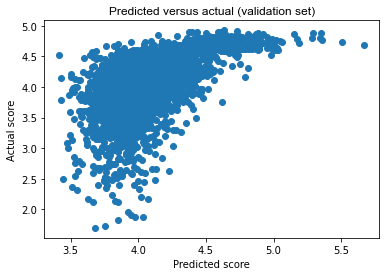

In [24]:
fig, ax = plt.subplots()
plt.scatter(y_pred,y_val)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

This model is overpredicting values

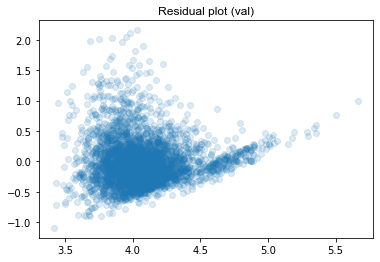

In [25]:
plt.scatter(check['pred'],check['resid'],alpha = 0.15)
plt.title('Residual plot (val)',family='arial',fontsize=12);

## Removing ratings and year

In [26]:
features2 = features.copy()
features2.remove('ratings')
features2.remove('year')

In [27]:
lr2 = LinearRegression()

lr2.fit(X_train[features2], y_train)

y_pred2 = lr2.predict(X_val[features2])
print('R^2 of linear regression on val set: {:.2f}'.format(lr2.score(X_val[features2], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred2))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred2))))

R^2 of linear regression on val set: 0.26
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.29


In [28]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features2].columns, lr2.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.10
containsAds : 0.09
editorsChoice : 0.10
top_developer : 0.54
installs_day : -0.00
updated_days : -0.00
has_video : 0.06
app_ads : 0.26
compatibility : 0.04
updates : -0.00
features : 0.88
bugs : 0.01
payments : 0.07
use_support : 0.06
genre_Adventure : -0.07
genre_Arcade : 0.04
genre_Art & Design : 0.02
genre_Auto & Vehicles : 0.10
genre_Beauty : -0.10
genre_Board : 0.09
genre_Books & Reference : 0.16
genre_Business : 0.14
genre_Card : 0.16
genre_Casino : 0.20
genre_Casual : -0.03
genre_Comics : -0.09
genre_Communication : 0.05
genre_Dating : 0.10
genre_Education : 0.06
genre_Entertainment : -0.04
genre_Events : -0.44
genre_Finance : 0.15
genre_Food & Drink : 0.15
genre_Health & Fitness : 0.11
genre_House & Home : 0.14
genre_Libraries & Demo : -0.16
genre_Lifestyle : 0.01
genre_Maps & Navigation : 0.09
genre_Medical : 0.02
genre_Music & Audio : 0.05
genre_News & Magazines : -0.02
genre_Parenting : 0.08
genre_Personalization : 0.13
genre_Photo

In [29]:
check2 = X_val.copy()
check2['score'] = y_val
check2['pred'] = lr2.predict(X_val[features2])
check2['resid'] = check2['pred'] - check2['score']

In [30]:
check2.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
14784,25281.0,1,0,0,0,354.609929,41,0,0.658800,0.043330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,4.029164,2.155741
2534,1372.0,1,1,0,0,578.703704,1118,0,0.227336,0.423020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.868613,4.022775,2.154162
6737,3502.0,1,1,0,0,660.938533,122,0,-0.001850,0.254856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.822857,3.873285,2.050428
18209,11487.0,1,1,0,0,580.383053,14,0,0.250500,0.129805,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.910268,3.960146,2.049879
3356,3121.0,1,1,0,0,1436.781609,271,0,0.343820,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.729299,3.778576,2.049276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20297,8592.0,1,0,0,0,329.597891,10,0,-0.147575,0.201421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.563927,3.691335,-0.872592
19015,27012.0,1,1,0,0,387.146729,1868,1,-0.018557,-0.377020,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.478712,3.583648,-0.895064
16204,45624.0,1,0,0,0,326.904217,882,0,-0.408433,0.190661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.702211,3.744260,-0.957952
16799,36398.0,1,0,0,0,1388.888889,75,0,-0.101625,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.592755,3.632976,-0.959780


## Removing installs / day

In [31]:
features3 = features2.copy()
features3.remove('installs_day')

In [32]:
lr3 = LinearRegression()

lr3.fit(X_train[features3], y_train)

y_pred3 = lr3.predict(X_val[features3])
print('R^2 of linear regression on val set: {:.2f}'.format(lr3.score(X_val[features3], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred3))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred3))))

R^2 of linear regression on val set: 0.26
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.29


In [33]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features3].columns, lr3.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.10
containsAds : 0.09
editorsChoice : 0.10
top_developer : 0.54
updated_days : -0.00
has_video : 0.06
app_ads : 0.26
compatibility : 0.04
updates : -0.00
features : 0.88
bugs : 0.01
payments : 0.07
use_support : 0.06
genre_Adventure : -0.07
genre_Arcade : 0.04
genre_Art & Design : 0.02
genre_Auto & Vehicles : 0.10
genre_Beauty : -0.10
genre_Board : 0.09
genre_Books & Reference : 0.16
genre_Business : 0.14
genre_Card : 0.16
genre_Casino : 0.20
genre_Casual : -0.03
genre_Comics : -0.09
genre_Communication : 0.06
genre_Dating : 0.10
genre_Education : 0.06
genre_Entertainment : -0.04
genre_Events : -0.44
genre_Finance : 0.15
genre_Food & Drink : 0.16
genre_Health & Fitness : 0.11
genre_House & Home : 0.14
genre_Libraries & Demo : -0.16
genre_Lifestyle : 0.01
genre_Maps & Navigation : 0.09
genre_Medical : 0.02
genre_Music & Audio : 0.05
genre_News & Magazines : -0.02
genre_Parenting : 0.08
genre_Personalization : 0.13
genre_Photography : -0.06
genre_

In [34]:
check3 = X_val.copy()
check3['score'] = y_val
check3['pred'] = lr3.predict(X_val[features3])
check3['resid'] = check3['pred'] - check3['score']

In [35]:
check3.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
2534,1372.0,1,1,0,0,578.703704,1118,0,0.227336,0.423020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.868613,4.023653,2.155040
14784,25281.0,1,0,0,0,354.609929,41,0,0.658800,0.043330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,4.027110,2.153687
3356,3121.0,1,1,0,0,1436.781609,271,0,0.343820,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.729299,3.781143,2.051844
6737,3502.0,1,1,0,0,660.938533,122,0,-0.001850,0.254856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.822857,3.872232,2.049375
18209,11487.0,1,1,0,0,580.383053,14,0,0.250500,0.129805,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.910268,3.958409,2.048142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20297,8592.0,1,0,0,0,329.597891,10,0,-0.147575,0.201421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.563927,3.690224,-0.873703
19015,27012.0,1,1,0,0,387.146729,1868,1,-0.018557,-0.377020,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.478712,3.583635,-0.895076
16799,36398.0,1,0,0,0,1388.888889,75,0,-0.101625,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.592755,3.634452,-0.958304
16204,45624.0,1,0,0,0,326.904217,882,0,-0.408433,0.190661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.702211,3.743778,-0.958434


## Removing updated days

In [36]:
features4 = features3.copy()
features4.remove('updated_days')

In [37]:
lr4 = LinearRegression()

lr4.fit(X_train[features4], y_train)

y_pred4 = lr4.predict(X_val[features4])
print('R^2 of linear regression on val set: {:.2f}'.format(lr4.score(X_val[features4], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format(mean_squared_error(y_val, y_pred4)))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred4))))

R^2 of linear regression on val set: 0.26
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.29


In [38]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features4].columns, lr4.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.10
containsAds : 0.09
editorsChoice : 0.11
top_developer : 0.55
has_video : 0.07
app_ads : 0.26
compatibility : 0.04
updates : -0.00
features : 0.90
bugs : 0.00
payments : 0.07
use_support : 0.06
genre_Adventure : -0.07
genre_Arcade : 0.04
genre_Art & Design : 0.04
genre_Auto & Vehicles : 0.12
genre_Beauty : -0.08
genre_Board : 0.11
genre_Books & Reference : 0.18
genre_Business : 0.16
genre_Card : 0.17
genre_Casino : 0.22
genre_Casual : -0.03
genre_Comics : -0.07
genre_Communication : 0.07
genre_Dating : 0.13
genre_Education : 0.08
genre_Entertainment : -0.02
genre_Events : -0.41
genre_Finance : 0.18
genre_Food & Drink : 0.19
genre_Health & Fitness : 0.13
genre_House & Home : 0.16
genre_Libraries & Demo : -0.17
genre_Lifestyle : 0.03
genre_Maps & Navigation : 0.12
genre_Medical : 0.04
genre_Music & Audio : 0.06
genre_News & Magazines : 0.01
genre_Parenting : 0.10
genre_Personalization : 0.13
genre_Photography : -0.05
genre_Productivity : 0.10
ge

In [39]:
check3 = X_val.copy()
check3['score'] = y_val
check3['pred'] = lr3.predict(X_val[features3])
check3['resid'] = check3['pred'] - check3['score']

In [40]:
check3.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
2534,1372.0,1,1,0,0,578.703704,1118,0,0.227336,0.423020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.868613,4.023653,2.155040
14784,25281.0,1,0,0,0,354.609929,41,0,0.658800,0.043330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,4.027110,2.153687
3356,3121.0,1,1,0,0,1436.781609,271,0,0.343820,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.729299,3.781143,2.051844
6737,3502.0,1,1,0,0,660.938533,122,0,-0.001850,0.254856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.822857,3.872232,2.049375
18209,11487.0,1,1,0,0,580.383053,14,0,0.250500,0.129805,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.910268,3.958409,2.048142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20297,8592.0,1,0,0,0,329.597891,10,0,-0.147575,0.201421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.563927,3.690224,-0.873703
19015,27012.0,1,1,0,0,387.146729,1868,1,-0.018557,-0.377020,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.478712,3.583635,-0.895076
16799,36398.0,1,0,0,0,1388.888889,75,0,-0.101625,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.592755,3.634452,-0.958304
16204,45624.0,1,0,0,0,326.904217,882,0,-0.408433,0.190661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.702211,3.743778,-0.958434


## Removing teen, bugs

In [41]:
features5 = features4.copy()
features5.remove('bugs')
features5.remove('contentRating_Teen')

In [42]:
lr5 = LinearRegression()

lr5.fit(X_train[features5], y_train)

y_pred5 = lr5.predict(X_val[features5])
print('R^2 of linear regression on val set: {:.2f}'.format(lr5.score(X_val[features5], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred5))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred5))))

R^2 of linear regression on val set: 0.26
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.29


In [43]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features5].columns, lr5.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.10
containsAds : 0.09
editorsChoice : 0.11
top_developer : 0.55
has_video : 0.07
app_ads : 0.26
compatibility : 0.04
updates : -0.00
features : 0.90
payments : 0.07
use_support : 0.06
genre_Adventure : -0.07
genre_Arcade : 0.04
genre_Art & Design : 0.03
genre_Auto & Vehicles : 0.12
genre_Beauty : -0.08
genre_Board : 0.11
genre_Books & Reference : 0.17
genre_Business : 0.16
genre_Card : 0.17
genre_Casino : 0.22
genre_Casual : -0.03
genre_Comics : -0.07
genre_Communication : 0.07
genre_Dating : 0.13
genre_Education : 0.07
genre_Entertainment : -0.03
genre_Events : -0.42
genre_Finance : 0.18
genre_Food & Drink : 0.18
genre_Health & Fitness : 0.13
genre_House & Home : 0.15
genre_Libraries & Demo : -0.17
genre_Lifestyle : 0.02
genre_Maps & Navigation : 0.12
genre_Medical : 0.04
genre_Music & Audio : 0.06
genre_News & Magazines : 0.01
genre_Parenting : 0.10
genre_Personalization : 0.13
genre_Photography : -0.05
genre_Productivity : 0.10
genre_Puzzle :

In [44]:
check5 = X_val.copy()
check5['score'] = y_val
check5['pred'] = lr5.predict(X_val[features5])
check5['resid'] = check5['pred'] - check5['score']

In [45]:
check5.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
2534,1372.0,1,1,0,0,578.703704,1118,0,0.227336,0.423020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.868613,4.082748,2.214135
14784,25281.0,1,0,0,0,354.609929,41,0,0.658800,0.043330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,4.000842,2.127420
3356,3121.0,1,1,0,0,1436.781609,271,0,0.343820,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.729299,3.765796,2.036496
18209,11487.0,1,1,0,0,580.383053,14,0,0.250500,0.129805,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.910268,3.941228,2.030960
6737,3502.0,1,1,0,0,660.938533,122,0,-0.001850,0.254856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.822857,3.853307,2.030450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12038,4384.0,1,0,0,0,338.409475,2,0,-0.228900,0.455350,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.517937,3.631226,-0.886711
20297,8592.0,1,0,0,0,329.597891,10,0,-0.147575,0.201421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.563927,3.676875,-0.887052
16204,45624.0,1,0,0,0,326.904217,882,0,-0.408433,0.190661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.702211,3.770781,-0.931430
16799,36398.0,1,0,0,0,1388.888889,75,0,-0.101625,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.592755,3.615532,-0.977223


## Removing sports, strategy, racing, news & magazines

In [46]:
features6 = features5.copy()
features6.remove('genre_Sports')
features6.remove('genre_Strategy')
features6.remove('genre_Racing')
features6.remove('genre_News & Magazines')

In [47]:
lr6 = LinearRegression()

lr6.fit(X_train[features6], y_train)

y_pred6 = lr6.predict(X_val[features6])
print('R^2 of linear regression on val set: {:.2f}'.format(lr6.score(X_val[features6], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred6))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred6))))

R^2 of linear regression on val set: 0.26
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.29


In [48]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features6].columns, lr6.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.10
containsAds : 0.09
editorsChoice : 0.11
top_developer : 0.55
has_video : 0.07
app_ads : 0.26
compatibility : 0.04
updates : -0.00
features : 0.90
payments : 0.07
use_support : 0.06
genre_Adventure : -0.07
genre_Arcade : 0.04
genre_Art & Design : 0.04
genre_Auto & Vehicles : 0.12
genre_Beauty : -0.08
genre_Board : 0.11
genre_Books & Reference : 0.17
genre_Business : 0.16
genre_Card : 0.17
genre_Casino : 0.22
genre_Casual : -0.03
genre_Comics : -0.07
genre_Communication : 0.07
genre_Dating : 0.13
genre_Education : 0.07
genre_Entertainment : -0.03
genre_Events : -0.42
genre_Finance : 0.18
genre_Food & Drink : 0.18
genre_Health & Fitness : 0.13
genre_House & Home : 0.15
genre_Libraries & Demo : -0.17
genre_Lifestyle : 0.02
genre_Maps & Navigation : 0.12
genre_Medical : 0.04
genre_Music & Audio : 0.06
genre_Parenting : 0.10
genre_Personalization : 0.13
genre_Photography : -0.05
genre_Productivity : 0.10
genre_Puzzle : 0.15
genre_Role Playing : -0.

In [49]:
check6 = X_val.copy()
check6['score'] = y_val
check6['pred'] = lr6.predict(X_val[features6])
check6['resid'] = check6['pred'] - check6['score']

In [50]:
check6.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
2534,1372.0,1,1,0,0,578.703704,1118,0,0.227336,0.423020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.868613,4.082312,2.213699
14784,25281.0,1,0,0,0,354.609929,41,0,0.658800,0.043330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,4.001091,2.127668
3356,3121.0,1,1,0,0,1436.781609,271,0,0.343820,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.729299,3.765794,2.036495
18209,11487.0,1,1,0,0,580.383053,14,0,0.250500,0.129805,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.910268,3.941051,2.030783
6737,3502.0,1,1,0,0,660.938533,122,0,-0.001850,0.254856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.822857,3.853275,2.030418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12038,4384.0,1,0,0,0,338.409475,2,0,-0.228900,0.455350,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.517937,3.631360,-0.886577
20297,8592.0,1,0,0,0,329.597891,10,0,-0.147575,0.201421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.563927,3.677104,-0.886823
16204,45624.0,1,0,0,0,326.904217,882,0,-0.408433,0.190661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.702211,3.771009,-0.931202
16799,36398.0,1,0,0,0,1388.888889,75,0,-0.101625,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.592755,3.615861,-0.976895


## Removing updates and mature

In [51]:
features7 = features6.copy()
features7.remove('contentRating_Mature 17+')
features7.remove('updates')

In [52]:
lr7 = LinearRegression()

lr7.fit(X_train[features7], y_train)

y_pred7 = lr7.predict(X_val[features7])
print('R^2 of linear regression on val set: {:.2f}'.format(lr7.score(X_val[features7], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred7))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred7))))

R^2 of linear regression on val set: 0.26
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.29


In [53]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features7].columns, lr7.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.10
containsAds : 0.09
editorsChoice : 0.11
top_developer : 0.55
has_video : 0.07
app_ads : 0.25
compatibility : 0.04
features : 0.90
payments : 0.07
use_support : 0.06
genre_Adventure : -0.07
genre_Arcade : 0.04
genre_Art & Design : 0.04
genre_Auto & Vehicles : 0.12
genre_Beauty : -0.08
genre_Board : 0.11
genre_Books & Reference : 0.18
genre_Business : 0.16
genre_Card : 0.18
genre_Casino : 0.22
genre_Casual : -0.03
genre_Comics : -0.08
genre_Communication : 0.07
genre_Dating : 0.11
genre_Education : 0.08
genre_Entertainment : -0.02
genre_Events : -0.42
genre_Finance : 0.18
genre_Food & Drink : 0.18
genre_Health & Fitness : 0.13
genre_House & Home : 0.16
genre_Libraries & Demo : -0.17
genre_Lifestyle : 0.03
genre_Maps & Navigation : 0.12
genre_Medical : 0.04
genre_Music & Audio : 0.06
genre_Parenting : 0.10
genre_Personalization : 0.13
genre_Photography : -0.05
genre_Productivity : 0.10
genre_Puzzle : 0.15
genre_Role Playing : -0.04
genre_Shoppin

In [54]:
check7 = X_val.copy()
check7['score'] = y_val
check7['pred'] = lr7.predict(X_val[features7])
check7['resid'] = check7['pred'] - check7['score']

In [55]:
check7.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
2534,1372.0,1,1,0,0,578.703704,1118,0,0.227336,0.423020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.868613,4.083289,2.214676
14784,25281.0,1,0,0,0,354.609929,41,0,0.658800,0.043330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,4.000138,2.126715
3356,3121.0,1,1,0,0,1436.781609,271,0,0.343820,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.729299,3.765066,2.035767
6737,3502.0,1,1,0,0,660.938533,122,0,-0.001850,0.254856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.822857,3.852810,2.029953
18209,11487.0,1,1,0,0,580.383053,14,0,0.250500,0.129805,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.910268,3.939315,2.029047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20297,8592.0,1,0,0,0,329.597891,10,0,-0.147575,0.201421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.563927,3.676222,-0.887705
12038,4384.0,1,0,0,0,338.409475,2,0,-0.228900,0.455350,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.517937,3.629424,-0.888513
16204,45624.0,1,0,0,0,326.904217,882,0,-0.408433,0.190661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.702211,3.771903,-0.930308
16799,36398.0,1,0,0,0,1388.888889,75,0,-0.101625,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.592755,3.633057,-0.959698


## Removing entertainment

In [56]:
features8 = features7.copy()
features8.remove('genre_Entertainment')

In [57]:
lr8 = LinearRegression()

lr8.fit(X_train[features8], y_train)

y_pred8 = lr8.predict(X_val[features8])
print('R^2 of linear regression on val set: {:.2f}'.format(lr8.score(X_val[features8], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred8))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred8))))

R^2 of linear regression on val set: 0.26
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.29


In [58]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features8].columns, lr8.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.10
containsAds : 0.09
editorsChoice : 0.11
top_developer : 0.55
has_video : 0.07
app_ads : 0.26
compatibility : 0.04
features : 0.90
payments : 0.07
use_support : 0.06
genre_Adventure : -0.06
genre_Arcade : 0.05
genre_Art & Design : 0.04
genre_Auto & Vehicles : 0.13
genre_Beauty : -0.07
genre_Board : 0.11
genre_Books & Reference : 0.18
genre_Business : 0.17
genre_Card : 0.18
genre_Casino : 0.23
genre_Casual : -0.02
genre_Comics : -0.07
genre_Communication : 0.08
genre_Dating : 0.12
genre_Education : 0.08
genre_Events : -0.41
genre_Finance : 0.19
genre_Food & Drink : 0.19
genre_Health & Fitness : 0.14
genre_House & Home : 0.16
genre_Libraries & Demo : -0.16
genre_Lifestyle : 0.03
genre_Maps & Navigation : 0.13
genre_Medical : 0.05
genre_Music & Audio : 0.07
genre_Parenting : 0.11
genre_Personalization : 0.14
genre_Photography : -0.04
genre_Productivity : 0.11
genre_Puzzle : 0.15
genre_Role Playing : -0.03
genre_Shopping : 0.18
genre_Simulation : 

In [59]:
check8 = X_val.copy()
check8['score'] = y_val
check8['pred'] = lr8.predict(X_val[features8])
check8['resid'] = check8['pred'] - check8['score']

In [60]:
check8.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
2534,1372.0,1,1,0,0,578.703704,1118,0,0.227336,0.423020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.868613,4.083859,2.215246
14784,25281.0,1,0,0,0,354.609929,41,0,0.658800,0.043330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.999701,2.126279
3356,3121.0,1,1,0,0,1436.781609,271,0,0.343820,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.729299,3.764845,2.035545
6737,3502.0,1,1,0,0,660.938533,122,0,-0.001850,0.254856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.822857,3.852619,2.029762
18209,11487.0,1,1,0,0,580.383053,14,0,0.250500,0.129805,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.910268,3.938678,2.028411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20297,8592.0,1,0,0,0,329.597891,10,0,-0.147575,0.201421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.563927,3.675189,-0.888738
12038,4384.0,1,0,0,0,338.409475,2,0,-0.228900,0.455350,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.517937,3.628673,-0.889264
16204,45624.0,1,0,0,0,326.904217,882,0,-0.408433,0.190661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.702211,3.770748,-0.931464
16799,36398.0,1,0,0,0,1388.888889,75,0,-0.101625,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.592755,3.632253,-0.960502


## Dropping casual

In [61]:
features9 = features8.copy()
features9.remove('genre_Casual')

In [75]:
lr9a = LinearRegression()

lr9a.fit(X_train[features9], y_train)

y_pred9a = lr9a.predict(X_train[features9])
print('R^2 of linear regression on val set: {:.2f}'.format(lr9.score(X_train[features9], y_train)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_train, y_pred9a))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_train, y_pred9a))))

R^2 of linear regression on val set: 0.27
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.28


In [76]:
lr9 = LinearRegression()

lr9.fit(X_train[features9], y_train)

y_pred9 = lr9a.predict(X_val[features9])
print('R^2 of linear regression on val set: {:.2f}'.format(lr9a.score(X_val[features9], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred9))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred9))))

R^2 of linear regression on val set: 0.26
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.29


In [77]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features9].columns, lr9a.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.10
containsAds : 0.09
editorsChoice : 0.11
top_developer : 0.55
has_video : 0.07
app_ads : 0.25
compatibility : 0.04
features : 0.90
payments : 0.07
use_support : 0.06
genre_Adventure : -0.05
genre_Arcade : 0.05
genre_Art & Design : 0.05
genre_Auto & Vehicles : 0.13
genre_Beauty : -0.07
genre_Board : 0.12
genre_Books & Reference : 0.19
genre_Business : 0.18
genre_Card : 0.19
genre_Casino : 0.23
genre_Comics : -0.06
genre_Communication : 0.08
genre_Dating : 0.13
genre_Education : 0.09
genre_Events : -0.40
genre_Finance : 0.20
genre_Food & Drink : 0.20
genre_Health & Fitness : 0.14
genre_House & Home : 0.17
genre_Libraries & Demo : -0.16
genre_Lifestyle : 0.04
genre_Maps & Navigation : 0.13
genre_Medical : 0.06
genre_Music & Audio : 0.07
genre_Parenting : 0.11
genre_Personalization : 0.15
genre_Photography : -0.04
genre_Productivity : 0.11
genre_Puzzle : 0.16
genre_Role Playing : -0.03
genre_Shopping : 0.19
genre_Simulation : -0.08
genre_Social : 

In [64]:
check9 = X_val.copy()
check9['score'] = y_val
check9['pred'] = lr9.predict(X_val[features9])
check9['resid'] = check9['pred'] - check9['score']

In [65]:
check9.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,...,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,score,pred,resid
2534,1372.0,1,1,0,0,578.703704,1118,0,0.227336,0.423020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.868613,4.083824,2.215211
14784,25281.0,1,0,0,0,354.609929,41,0,0.658800,0.043330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.873423,3.999876,2.126453
3356,3121.0,1,1,0,0,1436.781609,271,0,0.343820,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.729299,3.765241,2.035942
6737,3502.0,1,1,0,0,660.938533,122,0,-0.001850,0.254856,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.822857,3.852665,2.029808
18209,11487.0,1,1,0,0,580.383053,14,0,0.250500,0.129805,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.910268,3.938759,2.028492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20297,8592.0,1,0,0,0,329.597891,10,0,-0.147575,0.201421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.563927,3.675979,-0.887948
12038,4384.0,1,0,0,0,338.409475,2,0,-0.228900,0.455350,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.517937,3.629585,-0.888352
16204,45624.0,1,0,0,0,326.904217,882,0,-0.408433,0.190661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.702211,3.771280,-0.930932
16799,36398.0,1,0,0,0,1388.888889,75,0,-0.101625,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.592755,3.633150,-0.959605


### Test

In [66]:
X_test_cont = X_test[['free','containsAds','editorsChoice','top_developer','has_video', 'app_ads', 'compatibility', 'updates', 
        'features', 'bugs','payments', 'use_support']]

In [67]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_test[['genre','contentRating']])

ohe_x_test = ohe.transform(X_test[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=X_test.index)

In [68]:
#Merge cont and cat DFs
combo_test_df = pd.concat([X_test_cont, ohe_x_test_df], axis=1)

In [69]:
y_pred_test = lr9.predict(combo_test_df[features9])
print('R^2 of linear regression on val set: {:.2f}'.format(lr9.score(combo_test_df[features9], y_test)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_test, y_pred_test))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_test, y_pred_test))))

R^2 of linear regression on val set: 0.26
MSE of linear regression on val set: 0.14
MAE of linear regression on val set: 0.28


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


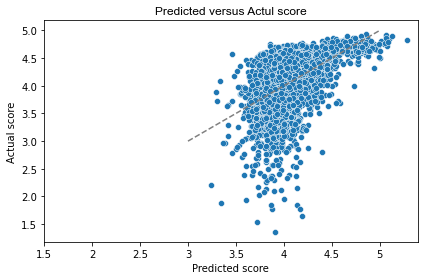

In [70]:
fig, ax = plt.subplots()
sns.scatterplot(y_pred_test,y_test)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(3,5,5), np.linspace(3,5,5), ls="--", c="0.5")
plt.tight_layout()
plt.title('Predicted versus Actul score',family='arial',fontsize=12);
#plt.xticks(np.linspace(2,5,7), ['2','2.5','3','3.5','4','4.5','5'])
plt.xticks(np.linspace(1.5,5,8), ['1.5','2','2.5','3','3.5','4','4.5','5'])
plt.tight_layout()
#plt.savefig('predictedactual_apps.svg');
plt.show;

In [71]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features9].columns, lr9.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.10
containsAds : 0.09
editorsChoice : 0.11
top_developer : 0.55
has_video : 0.07
app_ads : 0.25
compatibility : 0.04
features : 0.90
payments : 0.07
use_support : 0.06
genre_Adventure : -0.05
genre_Arcade : 0.05
genre_Art & Design : 0.05
genre_Auto & Vehicles : 0.13
genre_Beauty : -0.07
genre_Board : 0.12
genre_Books & Reference : 0.19
genre_Business : 0.18
genre_Card : 0.19
genre_Casino : 0.23
genre_Comics : -0.06
genre_Communication : 0.08
genre_Dating : 0.13
genre_Education : 0.09
genre_Events : -0.40
genre_Finance : 0.20
genre_Food & Drink : 0.20
genre_Health & Fitness : 0.14
genre_House & Home : 0.17
genre_Libraries & Demo : -0.16
genre_Lifestyle : 0.04
genre_Maps & Navigation : 0.13
genre_Medical : 0.06
genre_Music & Audio : 0.07
genre_Parenting : 0.11
genre_Personalization : 0.15
genre_Photography : -0.04
genre_Productivity : 0.11
genre_Puzzle : 0.16
genre_Role Playing : -0.03
genre_Shopping : 0.19
genre_Simulation : -0.08
genre_Social : 

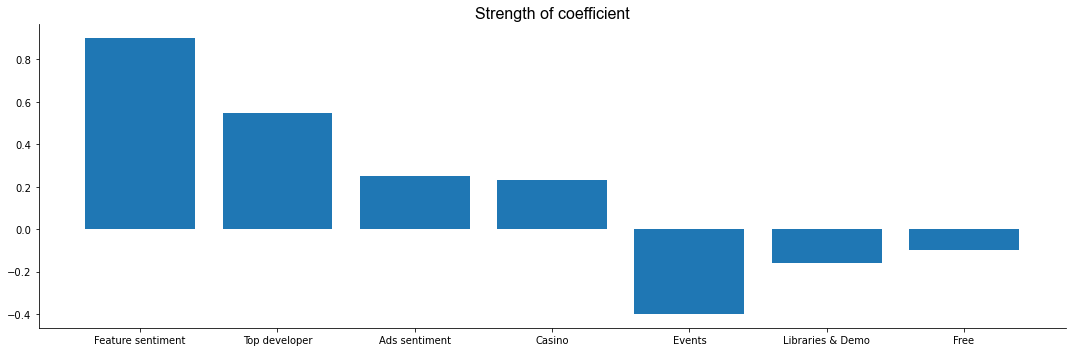

In [72]:
x_values = [0.90,0.55,0.25,0.23,-0.40,-0.16,-0.10]
x_labels = ['Feature sentiment','Top developer','Ads sentiment','Casino','Events','Libraries & Demo','Free']

plt.figure(figsize=[15,5])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.bar(x_labels,x_values)   
plt.title('Strength of coefficient',family='arial',fontsize=16)
plt.tight_layout()
plt.savefig('coefficients_apps.svg');
plt.show;

### Create dataframe for tableau

In [73]:
df_tableau = df.copy()
df_tableau = df_tableau.drop(columns=['installs','description','summary','histogram','released','currency',
                                     'sale','offersIAP','inAppProductPrice',
                                     'androidVersion','androidVersionText',
                                     'developer','developerId','privacyPolicy',
                                     'developerInternalID','genreId', 'icon', 'headerImage',
                                     'screenshots', 'video', 'videoImage',
                                     'updated', 'version', 'recentChanges', 'comments',
                                     'url','hist_clean','current_date',
                                     'contentRatingDescription','adSupported'])

In [74]:
df_tableau.to_csv('dataframe_tableau.csv')